# ECG PROJECT

by Erica Brisigotti (2097202), Ekaterina Chueva (2072050), Sofia Pacheco Garcia (2070771), Nadillia Sahputra (2070770)

In [1]:
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import fftpack, stats, signal
import pywt
from scipy import stats
import time

# firstly, I set
# - a saving option
FILE_SAVE = True
# - a second saving option for redudant yet maybe worth doing for small datasets
EXTRA_SAVE_FOR_SMALL_DATA = True
# - an option to show the structure of the datasets anayzed (both in general and for the specific chosen example)
SHOW_STRUCTURE = False
# - the color of the records from a healthier patient in plots
ch = 'aquamarine'
# - the color of the annotations from a healthier patient in plots
cha = 'navy'
# - an additional color for a healthier patient in plots
che = 'deepskyblue'
# - the color of the records from a more sick patient in plots
cs = 'darkorange'
# -  the color of the annotaitons from a more sick patient in plots
csa = 'red' 
# - an additional color for a healthier patient in plots
cse = 'gold'
# - an option for the classification algorithm (between xgboost and ??)
ML_ALGORITHM = 'xgboost'

# 1A. Data Preprocessing Example

To select the parameters for the preprocessing part, we select two random datasets, one from the first half and one from second half of the set of patients. Such a split is justified by the knowledge that the second half of patients is generally more sick (since it was purposefully introduced to insert more sick patients).

To reach such a goal, we upload the two WFDB records using the <code>rdrecord</code> function. They are uploaded as <code>wfdb.Record</code> objects, with many different attributes. Of such attributes, we are interested in the sampling frequency <code>.fs</code> and in the time series, which is stored under as <code>.p_signal</code>.

Similarly, the annotations for the two patients are uploaded using the <code>rdann</code> function, that retuns <code>wfdb.Record</code> objects with many attributes. Of such attributes, we are interested in the annotation indexes (saved as <code>.sample</code> ) and symbols (under <code>.symbol</code>).

In [2]:
address_1 = "100"
address_2 = "221"
record_1 = wfdb.rdrecord('input_files/'+address_1)
record_2 = wfdb.rdrecord('input_files/'+address_2)
ann_1 = wfdb.rdann('input_files/'+address_1,"atr")
ann_2 = wfdb.rdann('input_files/'+address_2,"atr")

if SHOW_STRUCTURE:
    print('the structure of the wfdb.Record object is:')
    display(record_1.__dict__)
    print(len(ann_1.sample), 'is the number of annotations in record',address_1)
    print(set(ann_1.symbol), 'are the unique annotations in record',address_1)
    print(len(ann_2.sample), 'is the number of annotations in record',address_2)
    print(set(ann_2.symbol), 'are the unique features in record',address_2)
    print('\n all the possible annotations are: ')
    wfdb.show_ann_labels()
    print('\nabout patient '+address_1)
    with open("input_files/"+address_1+".hea", 'r') as file:
        t = file.read().replace('#',"")
        hea = t.split('\n')
        print('\n',hea[3],": the first two data are info about the age and gender")
        temp = hea[3].split(" ")
        print(temp[1]," is the age of the patient and ",temp[2],"is the gender of the patient")
        print(hea[4],": are the meds the patient is on")
        print(hea[5],": are the notes for the patient")
    print('\nabout patient '+address_2)
    with open("input_files/"+address_1+".hea", 'r') as file:
        t = file.read().replace('#',"")
        hea = t.split('\n')
        print('\n',hea[3],": the first two data are info about the age and gender")
        temp = hea[3].split(" ")
        print(temp[1]," is the age of the patient and ",temp[2],"is the gender of the patient")
        print(hea[4],": are the meds the patient is on")
        print(hea[5],": are the notes for the patient")

In [3]:
s0_1 = record_1.p_signal[:,0]
s1_1 = record_1.p_signal[:,1]
a_1 = ann_1.sample
s0_2 = record_2.p_signal[:,0]
s1_2 = record_2.p_signal[:,1]
a_2 = ann_2.sample
freq = record_1.fs

We plot the records and annotations in both leads for both patients:

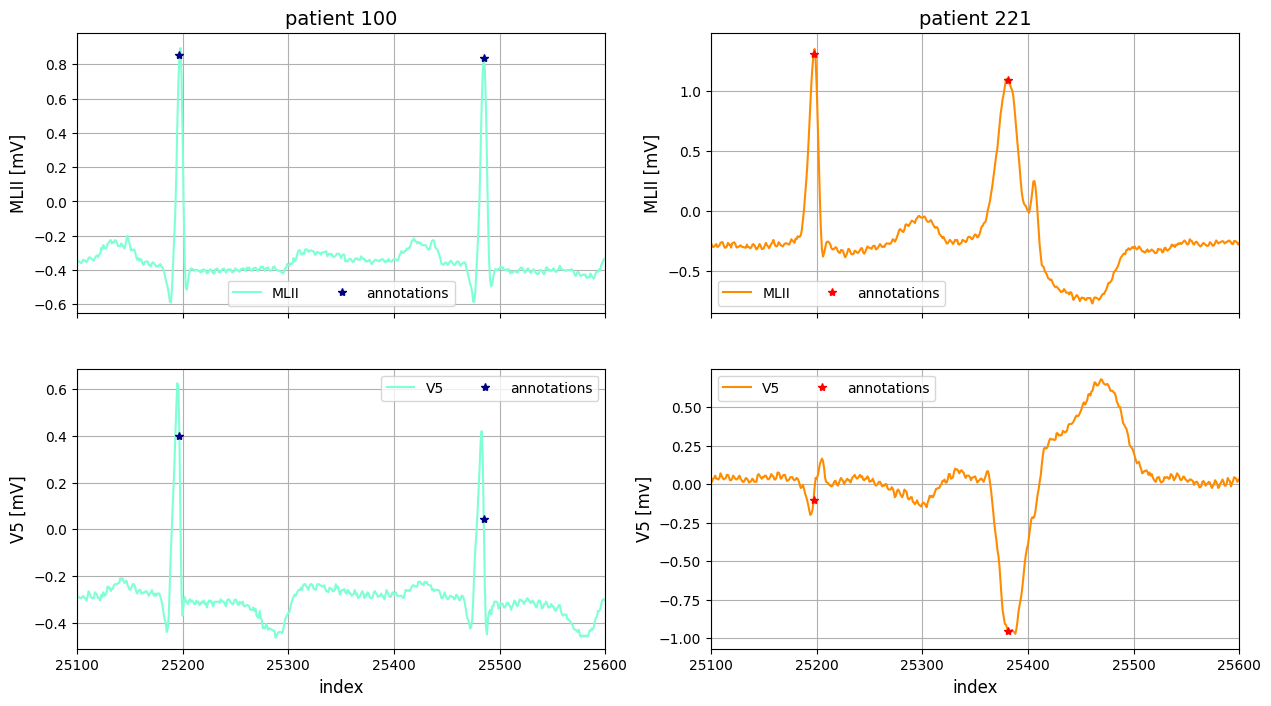

In [4]:
fig1, ax1 = plt.subplots(2,2,figsize = (15, 8), sharex = True)
start_point = 25100
end_point = start_point+500

ax1[0][0].plot(s0_1, '-', label='MLII', color=ch)
ax1[0][0].plot(a_1, s0_1[a_1], '*', label = 'annotations', color=cha)
ax1[0][0].set_xlim(start_point, end_point)
ax1[0][0].set_ylim(1.1*min(s0_1[start_point:end_point]), 1.1*max(s0_1[start_point:end_point]))
ax1[0][0].set_ylabel('MLII [mV]', fontsize=12)
ax1[0][0].set_title('patient '+address_1, fontsize=14)
ax1[0][0].legend(ncol=2, fontsize=10)
ax1[0][0].grid()

ax1[0][1].plot(s0_2, '-', label='MLII', color=cs)
ax1[0][1].plot(a_2, s0_2[a_2], '*', label='annotations', color=csa)
ax1[0][1].set_ylim(1.1*min(s0_2[start_point:end_point]), 1.1*max(s0_2[start_point:end_point]))
ax1[0][1].set_ylabel('MLII [mV]', fontsize=12)
ax1[0][1].set_title('patient '+address_2, fontsize=14)
ax1[0][1].legend(ncol=2, fontsize =10)
ax1[0][1].grid()

ax1[1][0].plot(s1_1, '-', label='V5', color=ch)
ax1[1][0].plot(a_1, s1_1[a_1], '*', label = 'annotations', color=cha)
ax1[1][0].set_ylim(1.1*min(s1_1[start_point:end_point]), 1.1*max(s1_1[start_point:end_point]))
ax1[1][0].set_xlabel('index', fontsize=12)
ax1[1][0].set_ylabel('V5 [mV]', fontsize=12)
ax1[1][0].legend(ncol=2, fontsize=10)
ax1[1][0].grid()

ax1[1][1].plot(s1_2, '-', label='V5', color=cs)
ax1[1][1].plot(a_2, s1_2[a_2], '*', label='annotations', color=csa)
ax1[1][1].set_ylim(1.1*min(s1_2[start_point:end_point]), 1.1*max(s1_2[start_point:end_point]))
ax1[1][1].set_xlabel('index', fontsize=12)
ax1[1][1].set_ylabel('V5 [mv]', fontsize=12)
ax1[1][1].legend(ncol=2, fontsize=10)
ax1[1][1].grid()

plt.show()

We see that, in general, the MLII signal is more aligned with annotations and has a higher signal-noise ratio. For this reason, it will be used to draw conclusions in the following chapters.

We implement filtering since the signal is visibly noisy and includes a baseline wonder. We filter with both fast Fourier transform and Wavelet transform tecniques, which are applied serially.

First of all, for the **Fast Fourier Transform**, we want to display and analyze the frequency spectra (which is extracted by the <code>power_fft</code> function).

In [5]:
def power_fft(vect, timestamp):
    vect_fft = fftpack.fft(vect)
    vect_power = np.abs(vect_fft)
    vect_all_freq = fftpack.fftfreq(vect.size, d = timestep)
    return vect_fft, vect_power, vect_all_freq

In [6]:
timestep = 1/freq
norm_fft_1, norm_power_1, norm_all_freq_1 = power_fft(s0_1, timestep)
norm_fft_2, norm_power_2, norm_all_freq_2 = power_fft(s0_2, timestep)

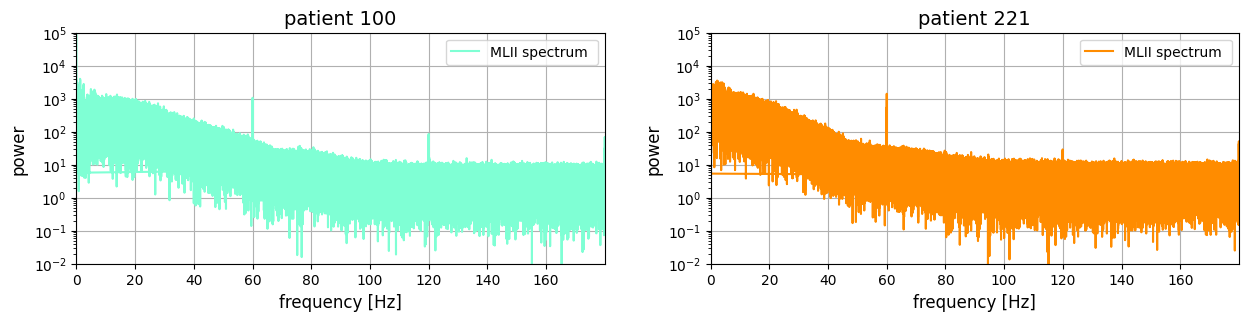

In [7]:
fig2, ax2 = plt.subplots(1, 2, figsize = (15, 3), sharex = True)

ax2[0].plot(norm_all_freq_1, norm_power_1, '-', label='MLII spectrum ', color=ch)
ax2[0].set_xlim(0,max(norm_all_freq_1))
ax2[0].set_ylim(10**(-2), 10**5)
ax2[0].set_yscale('log')
ax2[0].set_xlabel('frequency [Hz]', fontsize=12)
ax2[0].set_ylabel('power', fontsize=12)
ax2[0].set_title('patient '+address_1, fontsize=14)
ax2[0].legend(loc='upper right', ncol=2, fontsize=10)
ax2[0].grid()

ax2[1].plot(norm_all_freq_2, norm_power_2, '-', label='MLII spectrum ', color=cs)
ax2[1].set_ylim(10**(-2),10**5)
ax2[1].set_yscale('log')
ax2[1].set_xlabel('frequency [Hz]', fontsize=12)
ax2[1].set_ylabel('power', fontsize=12)
ax2[1].set_title('patient '+address_2, fontsize=14)
ax2[1].legend(loc='upper right', ncol=2, fontsize=10)
ax2[1].grid()

plt.show()

We notice a peak at around 60 Hz, which is due to the power supply of the recording device and must be discarded. We also see high values of the spectrum for low frequency, which should be discarded as well.

Therefore, we decide to implement a band-pass filter: the precise cut frequencies are chosen in the interval $[0.1-55]$ Hz.

In [8]:
down_freq_lim = np.array([0.1, 1, 2])
up_freq_lim = np.array([25, 35, 45])

We notice a peak at around 60 Hz, which is due to the power supply of the recording device and must be discarded. We also see high values of the spectrum for low frequency, which should be discarded as well.

Therefore, we decide to implement a band-pass filter: the precise cut frequencies are chosen in the interval $[0.1-50]$ Hz.

The cut frequency are chosen visually based on the results of their filtering (which is done by the <code>filtered_power</code>) that are shown in the plot below.


In [9]:
def filtered_power(vect_fft, vect_all_freq, down_freq_lim, up_freq_lim):
    vect_filtered_fft = vect_fft.copy()
    vect_filtered_fft[np.abs(vect_all_freq) >= up_freq_lim] = 0
    vect_filtered_fft[np.abs(vect_all_freq) <= down_freq_lim] = 0
    vect_filtered = (fftpack.ifft(vect_filtered_fft)).real
    return vect_filtered

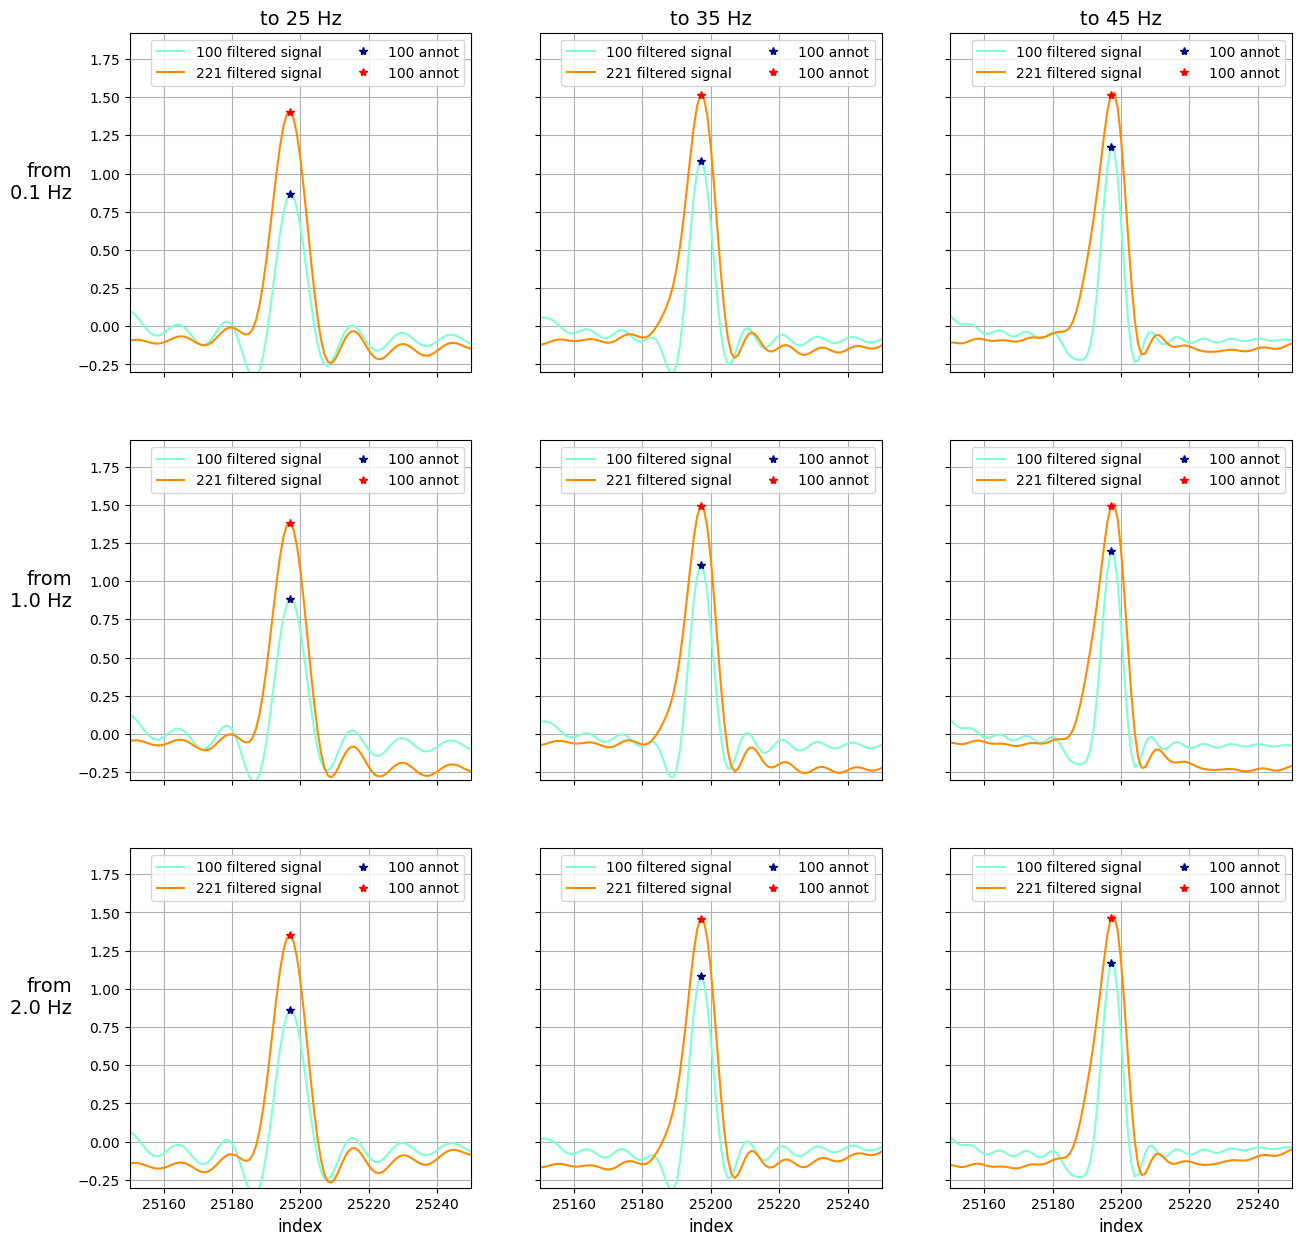

In [10]:
fig3, ax3 = plt.subplots(len(down_freq_lim), len(up_freq_lim), figsize = (15, 15), sharex=True, sharey=True)

start_point = 25150
end_point = start_point+100

for i in range(len(down_freq_lim)):
    for j in range(len(up_freq_lim)):
        norm_filtered_1 = filtered_power(norm_fft_1, norm_all_freq_1, down_freq_lim[i], up_freq_lim[j])
        x_1 = np.arange(0, len(norm_filtered_1), 1)
        norm_filtered_2 = filtered_power(norm_fft_2, norm_all_freq_2, down_freq_lim[i], up_freq_lim[j])
        temp = np.concatenate([norm_filtered_1[start_point:end_point],norm_filtered_2[start_point:end_point]])
        ax3[i][j].plot(norm_filtered_1, '-', label=address_1+' filtered signal', color=ch)
        ax3[i][j].plot(norm_filtered_2, '-', label=address_2+' filtered signal', color=cs)
        ax3[i][j].plot(a_1, norm_filtered_1[a_1], '*', label=address_1+' annot', color=cha)
        ax3[i][j].plot(a_2, norm_filtered_2[a_2], '*', label=address_1+' annot', color=csa)
        ax3[i][j].grid()
        ax3[i][j].legend(fontsize=10, ncol=2)
        ax3[i][j].set_xlim(start_point, end_point)
        ax3[i][j].set_ylim(1.3*min(temp), 1.3*max(temp))
        if i==0:
            ax3[i][j].set_title("to "+str(up_freq_lim[j])+" Hz", fontsize=14)
        if j==0:
            ax3[i][j].set_ylabel('from\n'+str(down_freq_lim[i])+" Hz", fontsize=14, rotation=0, ha="right")
        if i==(len(up_freq_lim)-1):
            ax3[i][j].set_xlabel('index', fontsize=12)

From the plots we can see that:
- for small upper limits (e.g. 10 Hz), the filtered signal is too smooth and there is loss of important information
- for intermediate upper limits (e.g. 30 Hz), the filtered signal is still quite noisy
- for nigher upper limits (e.g. 50 Hz), the filtered signal is smoother without major loss of information
- there is no visible variation coming from the different lower limits

Therefore, we decide to set:
- the lower cut frequency as the lowest value, 0.1 Hz
- the upper cut frequency as the highest value available, 50 Hz

In [11]:
down_freq_lim = 0.1
up_freq_lim = 50

We can now show the FFT filtered leads for both patients

In [12]:
norm_filtered_1 = filtered_power(norm_fft_1, norm_all_freq_1, down_freq_lim, up_freq_lim)
norm_fft_s0_1, norm_power_s0_1, norm_all_freq_s0_1 = power_fft(s0_1, timestep)
norm_fft_s0_2, norm_power_s0_2, norm_all_freq_s0_2 = power_fft(s0_2, timestep)
norm_fft_s1_1, norm_power_s1_1, norm_all_freq_s1_1 = power_fft(s1_1, timestep)
norm_fft_s1_2, norm_power_s1_2, norm_all_freq_s1_2 = power_fft(s1_2, timestep)
f_s0_1 = filtered_power(norm_fft_s0_1, norm_all_freq_s0_1, down_freq_lim, up_freq_lim)
f_s0_2 = filtered_power(norm_fft_s0_2, norm_all_freq_s0_2, down_freq_lim, up_freq_lim)
f_s1_1 = filtered_power(norm_fft_s1_1, norm_all_freq_s1_1, down_freq_lim, up_freq_lim)
f_s1_2 = filtered_power(norm_fft_s1_2, norm_all_freq_s1_2, down_freq_lim, up_freq_lim)

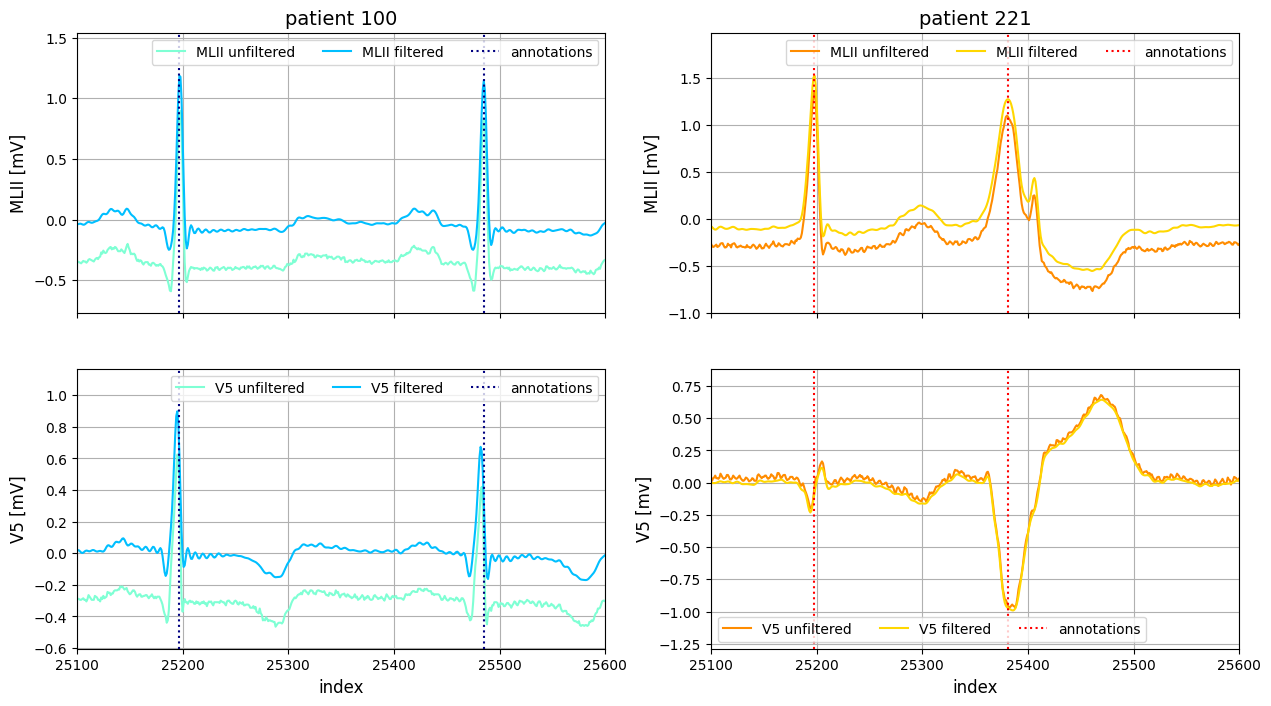

In [13]:
fig4, ax4 = plt.subplots(2,2,figsize = (15, 8), sharex = True)
start_point = 25100
end_point = start_point+500

ax4[0][0].plot(s0_1, '-', label='MLII unfiltered', color=ch)
ax4[0][0].plot(f_s0_1, '-', label='MLII filtered', color=che)
ax4[0][0].set_xlim(start_point, end_point)
temp = np.concatenate([s0_1[start_point:end_point], f_s0_1[start_point:end_point]])
ax4[0][0].vlines(a_1, 1.3*min(temp), 1.3*max(temp), linestyle='dotted', label = 'annotations', color=cha)
ax4[0][0].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[0][0].set_ylabel('MLII [mV]', fontsize=12)
ax4[0][0].set_title('patient '+address_1, fontsize=14)
ax4[0][0].legend(ncol=3, fontsize=10)
ax4[0][0].grid()

ax4[0][1].plot(s0_2, '-', label='MLII unfiltered', color=cs)
ax4[0][1].plot(f_s0_2, '-', label='MLII filtered', color=cse)
temp = np.concatenate([s0_2[start_point:end_point], f_s0_2[start_point:end_point]])
ax4[0][1].vlines(a_2, 1.3*min(temp), 1.3*max(temp), linestyle='dotted', label='annotations', color=csa)
ax4[0][1].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[0][1].set_ylabel('MLII [mV]', fontsize=12)
ax4[0][1].set_title('patient '+address_2, fontsize=14)
ax4[0][1].legend(ncol=3, fontsize=10)
ax4[0][1].grid()

ax4[1][0].plot(s1_1, '-', label='V5 unfiltered', color=ch)
ax4[1][0].plot(f_s1_1, '-', label='V5 filtered', color=che)
temp = np.concatenate([s1_1[start_point:end_point], f_s1_1[start_point:end_point]])
ax4[1][0].vlines(a_1, 1.3*min(temp), 1.3*max(temp), linestyle='dotted', label='annotations', color=cha)
ax4[1][0].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[1][0].set_xlabel('index', fontsize=12)
ax4[1][0].set_ylabel('V5 [mV]', fontsize=12)
ax4[1][0].legend(ncol=3, fontsize=10)
ax4[1][0].grid()

ax4[1][1].plot(s1_2, '-', label='V5 unfiltered', color=cs)
ax4[1][1].plot(f_s1_2, '-', label='V5 filtered', color=cse)
temp = np.concatenate([s1_2[start_point:end_point], f_s1_2[start_point:end_point]])
ax4[1][1].vlines(a_2, 1.3*min(temp), 1.3*max(temp), linestyle='dotted', label='annotations', color=csa)
ax4[1][1].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[1][1].set_xlabel('index', fontsize=12)
ax4[1][1].set_ylabel('V5 [mv]', fontsize=12)
ax4[1][1].legend(ncol=3, fontsize=10)
ax4[1][1].grid()

plt.show()

We filter the results shown above with **Wavelet transform** ... <span style="color:red"> [It's better if the person who wrote this explains this part of code] </span>

In [14]:
def wavelet(data): 
        w = pywt.Wavelet('sym4')
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        threshold = 0.04 # Threshold for filtering
        coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
        for i in range(1, len(coeffs)):
            coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        datarec = pywt.waverec(coeffs, 'sym4')
        return datarec

We can summarize both of the filtering steps into a single function. In the function, we also include the <code>stats.zscore</code> function that ... <span style="color:red"> [It's better if Nadillia explains this since she wrote this part of code] </span>

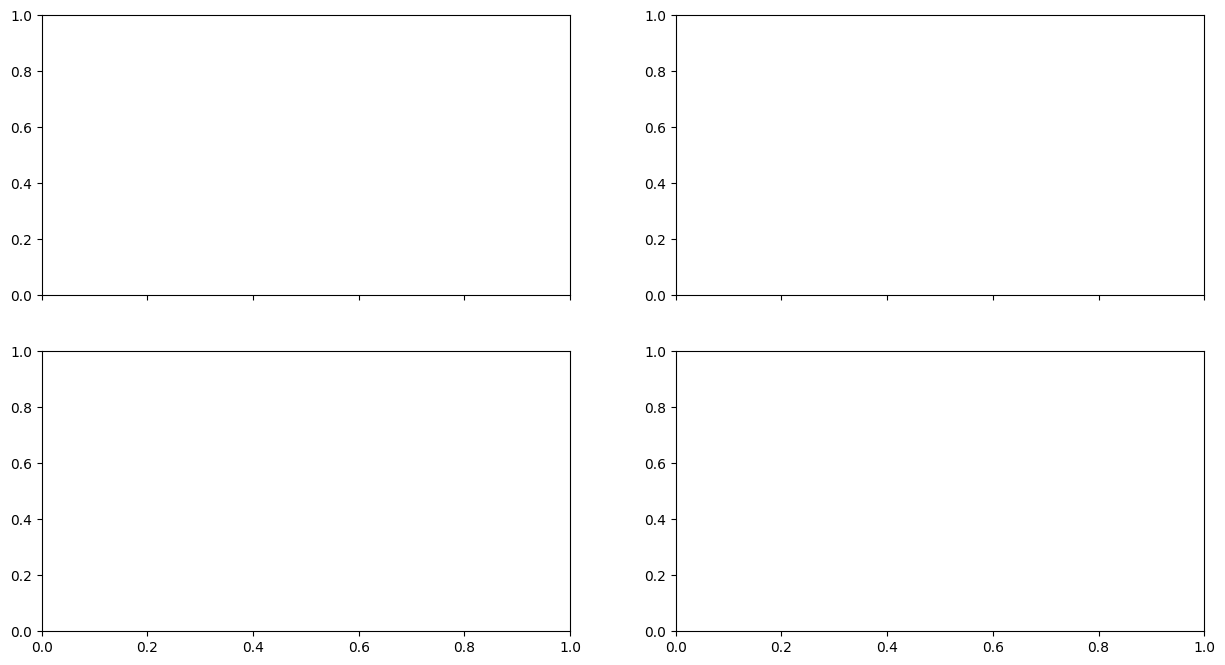

In [15]:
fig5, ax5 = plt.subplots(2,2,figsize = (15, 8), sharex = True)
start_point = 25100
end_point = start_point+500

# plot of filtered data after both filtering by basically copying & modifying fig4

# the original plot was the code below but displays just one patient and isn't in style with the previous one
# fig5, ax5 = plt.subplots(2,1,figsize = (15, 7))
# ax5[0].plot(s0) # asymmetric yet simple normalization
# ax5[0].plot(s1)
# ax5[0].set_xlim(2000,3000)
# ax5[0].set_ylim(-1,1)
# ax5[0].set_title("original data")
# ax5[1].plot(filtering(s0,freq,down_freq_lim,up_freq_lim))
# ax5[1].plot(filtering(s1,freq,down_freq_lim,up_freq_lim))
# ax5[1].set_xlim(2000,3000)
# ax5[1].set_ylim(-4,5)
# ax5[1].set_title("filtered data")
# plt.show()
# print(np.mean(filtering(s0,freq,down_freq_lim,up_freq_lim)),np.std(filtering(s0,freq,down_freq_lim,up_freq_lim)))
# print(np.mean(filtering(s1,freq,down_freq_lim,up_freq_lim)),np.std(filtering(s1,freq,down_freq_lim,up_freq_lim)))

In [16]:
def filtering(s,freq,down_freq_lim,up_freq_lim):
    def power_fft(vect, timestamp):
        vect_fft = fftpack.fft(vect)
        vect_power = np.abs(vect_fft)
        vect_all_freq = fftpack.fftfreq(vect.size, d = timestep)
        return vect_fft, vect_power, vect_all_freq
    timestep = 1/freq
    norm_fft, norm_power, norm_all_freq = power_fft(s, timestep)
    def filtered_power(vect_fft, vect_all_freq, down_freq_lim, up_freq_lim):
        vect_filtered_fft = vect_fft.copy()
        vect_filtered_fft[np.abs(vect_all_freq) >= up_freq_lim] = 0
        vect_filtered_fft[np.abs(vect_all_freq) <= down_freq_lim] = 0
        vect_filtered = (fftpack.ifft(vect_filtered_fft)).real
        return vect_filtered
    fft_filtered = filtered_power(norm_fft, norm_all_freq, down_freq_lim, up_freq_lim)
    def wavelet(data): 
        w = pywt.Wavelet('sym4')
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        threshold = 0.04 # Threshold for filtering
        coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
        for i in range(1, len(coeffs)):
            coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        datarec = pywt.waverec(coeffs, 'sym4')
        return datarec
    norm_filtered = stats.zscore(wavelet(fft_filtered))
    return norm_filtered

Lastly, to be safe we want to **eliminate the baseline wonder** of the signal to align the isoelectric line. We do this by substracting a low order polynomial function from the signal. <span style="color:red"> [It's better if Sofia checks this part since she wrote this part of code]. </span> Just like before, we use the <code>stats.zscore</code> function to standardize the output. 

In [17]:
def isoelectric_signal(s0, s1, freq):    
    y1=filtering(s0,freq,down_freq_lim,up_freq_lim)
    y2=filtering(s1,freq,down_freq_lim,up_freq_lim)
    x=range(len(y1))

    coefs_filt_1=np.polyfit(x, y1, 8, rcond=None, full=False, w=None, cov=False)
    coefs_filt_2=np.polyfit(x, y2, 8, rcond=None, full=False, w=None, cov=False)

    isoelectric_signal_1=y1-np.polyval(coefs_filt_1, x)
    isoelectric_signal_1 = stats.zscore(isoelectric_signal_1)
    isoelectric_signal_2=y2-np.polyval(coefs_filt_2, x)
    isoelectric_signal_2 = stats.zscore(isoelectric_signal_2)
    return (isoelectric_signal_1, isoelectric_signal_2)

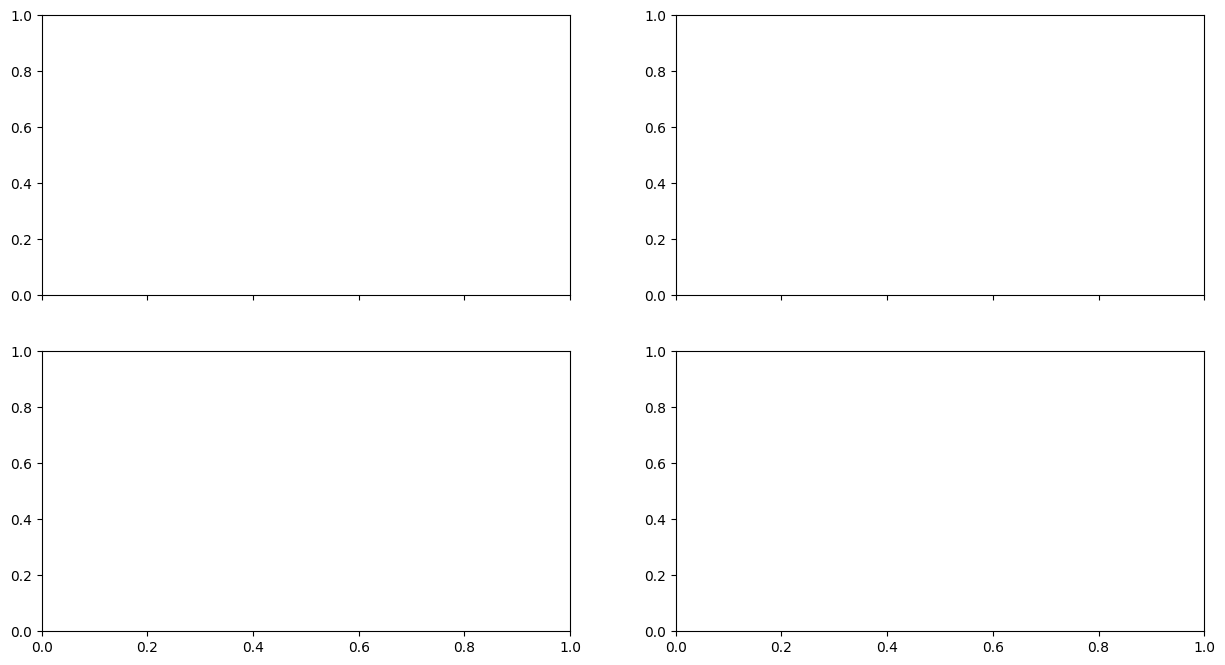

In [18]:
fig6, ax6 = plt.subplots(2,2,figsize = (15, 8), sharex = True)
start_point = 25100
end_point = start_point+500

# plot of filtered data after eliminating baselinewonder by basically copying & modifying fig4 and/or fig5

# the original plot was the code below but displays just one lead and one patient and isn't in style with the previous one
# fig6, ax6 = plt.subplots(1,2,figsize = (18, 8))
# ax6[0].plot(filtering(s0,freq,down_freq_lim,up_freq_lim))
# ax6[0].plot(filtering(s1,freq,down_freq_lim,up_freq_lim))
# ax6[0].set_xlim(2000,3000)
# ax6[0].set_ylim(-4,5)
# ax6[0].grid(True)
# ax6[0].set_title("filtered data")

# ax6[1].plot(isoelectric_signal(s0,s1,freq)[0])
# ax6[1].plot(isoelectric_signal(s0,s1,freq)[1])
# ax6[1].set_xlim(2000,3000)
# ax6[1].set_ylim(-4,5)
# ax6[1].grid(True)
# ax6[1].set_title("filtered and isoelectric data")
# plt.show()

# 1B) Data Preprocessing on the entire dataset

First of all, we store the additional information that we're able to interpret in a dataframe.

In [19]:
r = list(map(int,(np.loadtxt("input_files/RECORDS"))))
records = list(map(str,r))

if FILE_SAVE:
    t1 = time.time()
    age = [None]*len(records)
    gender = [None]*len(records)
    meds = [None]*len(records)
    notes = [None]*len(records)
    for i,path in enumerate(records):
        with open("input_files/"+path+".hea", 'r') as file:
            t = file.read().replace('#',"")
            hea = t.split('\n')
            temp = hea[3].split(" ")
            age[i] = int(temp[1])
            if (int(temp[1])<0):
                age[i] = float("NaN")
            gender[i] = temp[2]
            meds[i] = hea[4]
            notes[i] = hea[5]
    metadata = pd.DataFrame({"patient": records, "age": age, "gender": gender, "meds": meds, "notes": notes})
    outfn = 'output_files/'+"metadata"+'.csv'
    metadata.to_csv(outfn, index=False)
    t2 = time.time()
    print('the metadata saving took',t2-t1,'seconds')
else:
    metadata = pd.read_csv('output_files/metadata.csv')
    
metadata.head()

the metadata saving took 0.013033628463745117 seconds


,patient,age,gender,meds,notes
0,100,69.0,M,"Aldomet, Inderal",
1,101,75.0,F,Diapres,
2,102,84.0,F,Digoxin,The rhythm is paced with a demand pacemaker. ...
3,103,NaN,M,"Diapres, Xyloprim",
4,104,66.0,F,"Digoxin, Pronestyl",The rate of paced rhythm is close to that of ...


We avoid saving the unfiltered signal in a .csv format, but the option is there if needed: in such a case, the data relative to each patient is saved in a dataframe, in which each columns correspond to one lead.

In [20]:
r = list(map(int,(np.loadtxt("input_files/RECORDS"))))
records = list(map(str,r))

if EXTRA_SAVE_FOR_SMALL_DATA:
    t1 = time.time()
    for path in records:
        # Load the record
        record = wfdb.rdrecord("input_files/"+path)

        # Get the MLII and V5 signals
        mlii = record.p_signal[:, 0]
        v5 = record.p_signal[:, 1]

        # Create a DataFrame with the signals
        df = pd.DataFrame({'MLII': mlii, 'V5': v5})

        # Save the DataFrame to a CSV file
        outfn = 'output_files/'+'data'+path+'.csv'
        df.to_csv(outfn, index=False)
    t2 = time.time()
    print('the metadata saving took',t2-t1,'seconds')

the metadata saving took 55.80108308792114 seconds


We then save the annotations in .cvs format by creating, for each patient, a dataframe with a index and a symbol column:

In [21]:
# save annotations in csv
if FILE_SAVE:
    t1 = time.time()
    for path in records:
        # Read the annotation file for record 100
        annotation = wfdb.rdann("input_files/"+path, 'atr')

        # Create a pandas DataFrame with the annotation data
        df = pd.DataFrame({'index': annotation.sample.tolist(), 'symbol': annotation.symbol})

        # Save the DataFrame to a CSV file
        outfn = 'output_files/'+'data'+path+'_ann.csv'
        df.to_csv(outfn, index=False)
    t2 = time.time()
    print('the annotation saving took',t2-t1,'seconds')

the annotation saving took 1.2023932933807373 seconds


Finally, we save the filtered signal in a .csv format: the data relative to each patient is saved in a dataframe, in which each columns correspond to one lead.

In [22]:
# save filtered signal in csv
r = list(map(int,(np.loadtxt("input_files/RECORDS"))))
records = list(map(str,r))

if FILE_SAVE:
    t1 = time.time()
    for path in records:
        # Load the record
        record = wfdb.rdrecord("input_files/"+path)

        # Get the MLII and V5 signals
        s0 = record.p_signal[:,0]
        s1 = record.p_signal[:,1]

        # Create a DataFrame with the signals
        df = pd.DataFrame({'MLII': isoelectric_signal(s0,s1,freq)[0], 'V5': isoelectric_signal(s0,s1,freq)[1], })

        # Save the DataFrame to a CSV file
        outfn = "output_files/"+"data"+path+'_filtered.csv'
        df.to_csv(outfn, index=False)
    t2 = time.time()
    print('the filtered data saving took',t2-t1,'seconds')

the filtered data saving took 203.3030219078064 seconds


# 2) Segmentation

In [23]:
def segmentation(annotations):
# function that performs segmentation based on the relative known proportions between RR, PR and QT 
# the function returns
    ann = np.array(annotations['index'])
    
    # I initialize the variables I need for the while loop
    patient_start = np.ones(2)*-3
    j = -1
    while np.any(patient_start<0):
        j += 1
        # I calculate the RR intervals
        RR_intervals = (ann[(j+1):]-ann[j:-1])
        # firstly, I crop the RR interval to match the relative proportion of RR:QT=0.8:0.41 
        QT_size = (RR_intervals*0.41/0.8).astype(int)
        PR_size = (RR_intervals*0.16/0.8).astype(int)
        patient_start = ann[j:-1] - PR_size
        patient_end = ann[j:-1] + QT_size
    # j is the number of annotations ignored from the beginning
    # i is the number of annotations ignored from the end
    # once I've made sure that the annotations are aligned, I delete the first and last one just to be safe
    RR_intervals = RR_intervals[1:-1]
    QT_size = QT_size[1:-1]
    PR_size = PR_size[1:-1]
    patient_start = ann[j+1:-2] - PR_size
    patient_end = ann[j+1:-2] + QT_size
    patient_R_peak = ann[j+1:-2]
    patient_ann = list(annotations['symbol'][j+1:-2])
    return RR_intervals, QT_size, PR_size, patient_start, patient_end, patient_R_peak, patient_ann

In [24]:
r = list(map(int,(np.loadtxt("input_files/RECORDS"))))
records = list(map(str,r))
FILE_SAVE=True

if FILE_SAVE:
    t1 = time.time()
    
    # we want to save a dataframe of heartbeats: to do that, I initialize some temporary means of storage
    # - the number that identifies the patient
    number = np.array([0])
    # - the number that identifies the heartbeat of each patient
    idx = np.array([0])
    # - the index of the start of the heartbeat
    start = np.array([0])
    # - the index of the end of the heartbeat
    end = np.array([0]) 
    # - the index of the R peak of the heartbeat
    R_peak = np.array([0]) 
    # - the symbol for the annotation of the heartbeat
    annot = [None] 
    # - the duration of the heartbeat
    RR = np.array([0])
    
    # I then fill such temporary means of storage by updating them after analyzing every file/patient
    for path in records:
        # UPLOAD: since we don't use the signal at this step, it doesn't matter if it's filtered or not
        # data = pd.read_csv("output_files/data"+path+".csv")
        annotations = pd.read_csv("output_files/data"+path+"_ann.csv")
        ann = np.array(annotations['index'])
        
        # and use my custom function for SEGMENTATION
        patient_RR, QT_size, PR_size, patient_start, patient_end, patient_R_peak, patient_ann = segmentation(annotations)
        #print(path,patient_start[0])
        # I add the remaining pieces of information
        # - the number of the patient is the same for all its heartbeats
        patient_number = np.ones_like(patient_start)*int(path)
        # - the number that identifies the heartbeat of each patient is a simple increasing vector of integers
        patient_idx = np.arange(0,len(patient_start),1,dtype = int)
#         # - the location of the R peaks (by cropping the annotations accordingly)
#         patient_R_peak = ann[j:-i]
#         # - the symbols for the annotations (by cropping the annotations accordingly)
#         patient_ann = list(annotations['symbol'][j:-i])
        
        # lastly, I check that all the annotations are in between the corresponding starts and stops
        check = np.all([(patient_R_peak>patient_start),(patient_R_peak<patient_end)])
        if not check:
            print(check)
           
        # and update the temporary means of storage
        number = np.concatenate((number, patient_number))
        idx = np.concatenate((idx, patient_idx))
        start = np.concatenate((start, patient_start))
        end = np.concatenate((end, patient_end))
        R_peak = np.concatenate((R_peak, patient_R_peak))
        annot.extend(patient_ann)
        RR = np.concatenate((RR,patient_RR))
    
    # finally, I put together the heartbeat dataframe  
    #print(len(number[1:]),len(idx[1:]),len(start[1:]),len(end[1:]),len(R_peak[1:]),len(annot[1:]),len(RR[1:]))
    hb = pd.DataFrame({"patient": number[1:], "idx": idx[1:], "start": start[1:], "end": end[1:],
                       "R_peak": R_peak[1:], "ann": annot[1:], "RR": RR[1:] })
    t2 = time.time()
    print("the segmentation algorithm took",t2-t1,'seconds')
    outfn = 'output_files/heartbeats.csv'
    hb.to_csv(outfn, index=False)
else:
    hb = pd.read_csv('output_files/heartbeats.csv')
    
display(hb)

the segmentation algorithm took 0.3210434913635254 seconds


,patient,idx,start,end,R_peak,ann,RR
0,100,0,19,227,77,N,293
1,100,1,312,519,370,N,292
2,100,2,606,807,662,N,284
3,100,3,889,1092,946,N,285
4,100,4,1175,1376,1231,N,284
...,...,...,...,...,...,...,...
112480,234,2756,648269,648438,648316,N,240
112481,234,2757,648508,648679,648556,N,241
112482,234,2758,648749,648921,648797,N,243
112483,234,2759,648990,649169,649040,N,252


# 3) Extraction of features
From the previous step, we already have extracted the RR period, which is strictly related to the heartbeat frequency.

# 3A) Wavelet transform coefficients extraction

<span style="color:red"> [It's better if Katya writes this part and inserts here code below here since she's more knowledgeable about it]. </span>

In [25]:
t1 = time.time()

# see Katya's algorithm

t2 = time.time()
print("the extraction of wavelet features took",t2-t1,'seconds')

the extraction of wavelet features took 0.0 seconds


# 3B) Extraction of visualizable features:
For each heartbeat, we extract and store
- the beginning, end, duration, height of the R, P, T peaks
- maximum and minimum of the signal
- the P-R, R-T period
- a frequency spectrum for a chosen interval of frequencies

<span style="color:red"> [For other features to extract, we need to read the printed article since there are huge tables of choices for the hand-extracted features]. </span>

In [26]:
t1 = time.time()

# part is Erica's code that needs to be inserted, part needs to be done

t2 = time.time()
print("the extraction of visualizable features took",t2-t1,'seconds')

the extraction of visualizable features took 0.0 seconds


# 4) Machine Learning

In [27]:
if ML_ALGORITHM=='xgboost':
    t1 = time.time()
    
    # xgboost algorithm here from Katya
    
    t2 = time.time()
    print("the "+ML_ALGORITHM+" ML algorithm took",t2-t1,'seconds')
else:
    t1 = time.time()
    # we also need to try to implement a simple classifier (suggested by Federico)
    t2 = time.time()
    print("the "+ML_ALGORITHM+" ML algorithm took",t2-t1,'seconds')

the xgboost ML algorithm took 0.0 seconds
